In [139]:
import numpy as np; import numba as nb; import math; import cmath

def gen_basis_state(n_states: int):
    return np.eye(n_states)

def normalize_states_np(coefficients: np.ndarray[complex]):
    if len(coefficients.shape) > 1:
        raise Exception('coefficients array needs to be 1D')
    euclidean_norm = np.sum(np.abs(coefficients)**2)
    return coefficients/ math.sqrt(euclidean_norm) # Euclidean norm should be real  and > 0 hence using math library will throw error if obtains a complex value or value <0

@nb.njit(['c16[:](c16[:])', 'f8[:](f8[:])'], parallel = True)
def normalize_states_numba(coefficients: np.ndarray[complex]):

    if len(coefficients.shape) > 1:
        raise Exception('coefficients array needs to be 1D')
    
    euclidean_norm = 0
    for i in nb.prange(coefficients.size):
        euclidean_norm += abs(coefficients[i])**2

    for i in nb.prange(coefficients.size):
        coefficients[i] /= math.sqrt(euclidean_norm)
    return coefficients

def inner_product_np(state1: np.ndarray[complex], state2: np.ndarray[complex]):
    if (len(state1.shape) > 1) | (len(state2.shape) > 1):
        raise Exception('state arrays needs to be 1D')
    if state1.size != state2.size:
        raise Exception('state arrays need to be same size')
    return np.dot(np.conj(state1), state2)

@nb.njit(['c16(c16[:], c16[:])','f8(c16[:], c16[:])', 'f8(f8[:], f8[:])'])
def inner_product_numba(state1: np.ndarray[complex], state2: np.ndarray[complex]):
    if (len(state1.shape) > 1) | (len(state2.shape) > 1):
        raise Exception('state arrays needs to be 1D')
    if state1.size != state2.size:
        raise Exception('state arrays need to be same size')
    inner_prod = 0
    for i in range(state1.size):
        inner_prod += state1[i].conjugate()*state2[i]
    return inner_prod

def measure_state_np(state: np.ndarray[complex], measurements: int): # lazy implementation
    if len(state.shape) > 1:
        raise Exception('state array needs to be 1D')
    return np.random.choice(np.arange(state.size), p = np.abs(state)**2, size = measurements)

@nb.njit(['uint32[:](c16[:], uint32)', 'uint32[:](f8[:], uint32)'], parallel = True) # could be optimised
def measure_state_numba(state: np.ndarray[complex], measurements: int):
    if len(state.shape) > 1:
        raise Exception('state array needs to be 1D')
    random_uniform = np.random.rand(measurements)
    indexes = np.arange(state.size)
    cumulative_probability_density = np.cumsum(np.abs(state)**2)
    template = np.empty(measurements, dtype=np.uint32)
    for i in nb.prange(measurements):
        for j in range(state.size):
            if j == 0:
                if (random_uniform[i] > 0) & (random_uniform[i] < cumulative_probability_density[j]):
                    template[i] = indexes[j]
            elif j < (state.size - 1):
                if (random_uniform[i] > cumulative_probability_density[j-1]) & (random_uniform[i] < cumulative_probability_density[j]):
                    template[i] = indexes[j]
            elif j == (state.size - 1):
                if (random_uniform[i] > cumulative_probability_density[j-1]) & (random_uniform[i] < 1):
                    template[i] = indexes[j]
    return template

@nb.njit(['c16[:](c16[:,:], c16[:])', 'f8[:](f8[:,:], f8[:])', 'f8[:](c16[:,:], c16[:])'], parallel = True)
def apply_unitary_transform(unitary_matrix, state):
    if len(state.shape) > 1:
        raise Exception('state array needs to be 1D')
    if (unitary_matrix.shape[0] != state.size) | (unitary_matrix.shape[1] != state.size):
        raise Exception('unitary matrix and state must have have same size across all dimensions')
    new_state = np.empty_like(state)
    for i in nb.prange(unitary_matrix.shape[0]):
        tmp = 0
        for j in range(unitary_matrix.shape[1]):
            tmp += unitary_matrix[i,j] * state[j]
        new_state[i] = tmp
    return new_state

def apply_quantum_algorithm(state_0, unitary_matrix, measurements):
    new_state = apply_unitary_transform(unitary_matrix, state_0)
    return measure_state_numba(new_state, measurements)
    


In [62]:
tests = 4
test_state = np.random.rand(tests) + np.random.rand(tests)*1j
norm_test_state = normalize_states_numba(test_state)

print(np.linalg.norm(norm_test_state))

0.9999999999999999


In [63]:
tests = 100000
test_state = np.random.rand(tests) + np.random.rand(tests)*1j

%timeit normalize_states_np(test_values)
%timeit normalize_states_numba(test_values)
%timeit normalize_states_numba_p(test_values)

618 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


KeyboardInterrupt: 

In [55]:
basis = gen_basis_state(2)
print(inner_product_numba(basis[0], basis[0]))
print(inner_product_numba(basis[0], basis[1]))
print(inner_product_numba(basis[1], basis[0]))
print(inner_product_numba(basis[1], basis[1]))

1.0
0.0
0.0
1.0


In [45]:
tests = 100000
test_state1 = np.random.rand(tests) + np.random.rand(tests)*1j
test_state2 = np.random.rand(tests) + np.random.rand(tests)*1j
norm_test_state1 = normalize_states_numba(test_state1)
norm_test_state2 = normalize_states_numba(test_state2)

%timeit inner_product_np(norm_test_state1, norm_test_state2)
%timeit inner_product_numba(norm_test_state1, norm_test_state2)


449 µs ± 6.86 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
79.3 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


658 µs ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.61 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<BarContainer object of 40 artists>

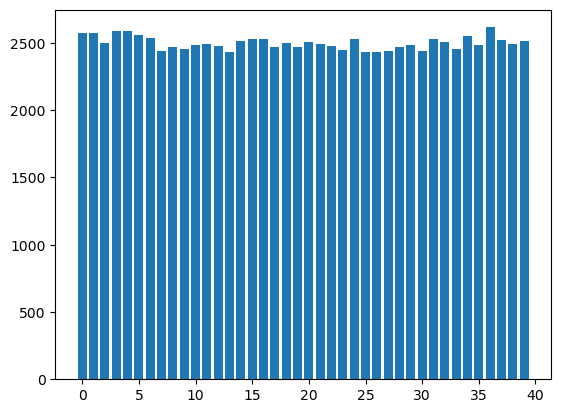

In [124]:
import matplotlib.pyplot as plt
tests = 40
measurements = 100000
test_state = np.ones(tests) + np.ones(tests)*1j
output = measure_state_numba(norm_test_state, 100000)
np.histogram(output)
hist = np.histogram(measure_state_numba(norm_test_state, 100000),bins= np.arange(tests+1))
plt.bar(np.arange(tests), hist[0])

%timeit measure_state_numba(norm_test_state, 100000)
%timeit measure_state_np(norm_test_state, 100000)

In [136]:
unitary_matrix = np.array(((1,1),(1,-1)))/ np.sqrt(2)

basis = gen_basis_state(2)
print(basis[0])
out = apply_unitary_transform(unitary_matrix, basis[0])
print(out)

[1. 0.]
[0.70710678 0.70710678]


In [141]:
basis = gen_basis_state(2)
unitary_matrix = np.array(((1,1),(1,-1)))/ np.sqrt(2)
measurements = 100
meas_lst = apply_quantum_algorithm(basis[0], unitary_matrix, 100)
print(meas_lst)

[1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0
 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1]
